In [9]:
from typing import List
from copy import deepcopy

import collections
import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

import pyscf
import pyscf.cc
import pyscf.mcscf

# To get molecular geometries.
import openfermion as of
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import BitArray
from qiskit_aer import AerSimulator  # For MPS Simulator.
from qiskit.primitives import StatevectorEstimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer.primitives import EstimatorV2 as Estimator

import ffsim

# To run on hardware.
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

from functools import partial, reduce

import numpy as np

# from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch
from qiskit_addon_sqd.qubit import solve_qubit, sort_and_remove_duplicates

from adaptvqe.pools import DVG_CEO, FullPauliPool, TiledPauliPool
from adaptvqe.convert import cirq_pauli_sum_to_qiskit_pauli_op
from adaptvqe.hamiltonians import XXZHamiltonian
from adaptvqe.algorithms.adapt_vqe import LinAlgAdapt, TensorNetAdapt

In [2]:
ibm_computer: str = "ibm_fez"

service = qiskit_ibm_runtime.QiskitRuntimeService(channel="local")
computer = service.backend()
sampler = Sampler(computer)

/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/qiskit_ibm_runtime/fake_provider/backends/nighthawk/fake_nighthawk.py:76: UserWarning: Properties of fake_nighthawk are not intended to represent typical nighthawk error values.
  warnings.warn(


## Build a tiled pool

In [32]:
max_mpo_bond = 100
dmrg_mps_bond = 10
adapt_mps_bond = 10
l = 4

j_xy = 1
j_z = 1
h = XXZHamiltonian(j_xy, j_z, l, diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond)
dmrg_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")
pool = FullPauliPool(n=l, max_mpo_bond=max_mpo_bond)

# Run 200 iterations of ADAPT-VQE for small problem instance, selecting randomly among degenerate gradients.
# Form a list of all unique operators ever selected for this small instance.
ixs = []
for _ in range(30):
    my_adapt = LinAlgAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=False,
        threshold=10**-5,
        max_adapt_iter=5,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=100,
        max_mps_bond = 20
    )
    my_adapt.run()
    data = my_adapt.data
    for i in data.result.ansatz.indices:
        if i not in ixs:
            ixs.append(i)

print(f"Pool will be tiled from {len(ixs)} ops")
source_ops = [pool.operators[index].operator for index in ixs]

Got DMRG energy -6.46410e+00

Initial energy: -3.0

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265423
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.0)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.23606797749979
(change of -1.2360679774997898)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685638066
Operators under consideration (1):
[79]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.0)]
Operator(s) added to ansatz: [79]
Initial energy: -4.23606797749979
Optimizing energy with indices [244, 79]...
Starting point: [np.float64(0.5535743589121112), np.float64(0.0)]

Current energy: -6.0
(change of -1.7639320225002102)
Cur

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -4.23606797749979
(change of -1.2360679774997898)
Current ansatz: [241]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685638066
Operators under consideration (1):
[31]
Corresponding gradients (ordered by magnitude):
[np.float64(4.0)]
Operator(s) added to ansatz: [31]
Initial energy: -4.23606797749979
Optimizing energy with indices [241, 31]...
Starting point: [np.float64(-0.5535743589121112), np.float64(0.0)]

Current energy: -6.0
(change of -1.7639320225002102)
Current ansatz: [241, 31]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132712
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0)]
Operator(s) added to ansatz: [228]
Initial energy: -6.0
Optimizing energy with indices [241, 31, 228]...
Starting point: [np.float64(-0.7853981634264061), np.f

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137754
Error: 1.7763568394002505e-15
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [241, 31, 228, 210, 201]
Coefficients: [np.float64(-0.7853981633974476), np.float64(-0.7853981633974477), np.float64(0.13089969389957476), np.float64(0.16991845472706105), np.float64(0.13089969389957481)]

Initial energy: -3.0

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265423
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.0)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.23606797749979
(change of -1.2360679774997898)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gr

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615137754
(change of -0.13682546031637166)
Current ansatz: [244, 79, 225, 210, 156]
Performing final convergence check...
Total gradient norm: 3.154465042502331e-07

Convergence condition achieved!

Final Energy: -6.464101615137754
Error: 1.7763568394002505e-15
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [244, 79, 225, 210, 156]
Coefficients: [np.float64(0.7853981593401244), np.float64(0.7853981493607413), np.float64(-0.13089969397486864), np.float64(0.1699184550541404), np.float64(0.13089969095908266)]

Initial energy: -3.0

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265423
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.0)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.2360679774997

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 6.240962174378714
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.089491618578594)]
Operator(s) added to ansatz: [198]
Initial energy: -6.327276154821382
Optimizing energy with indices [244, 79, 216, 225, 198]...
Starting point: [np.float64(0.7853981467683384), np.float64(0.7853981446408085), np.float64(-0.16356985846360111), np.float64(-0.16356985766358637), np.float64(0.0)]

Current energy: -6.464101615137755
(change of -0.13682546031637344)
Current ansatz: [244, 79, 216, 225, 198]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137755
Error: 8.881784197001252e-16
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [244, 79, 216, 225, 198]
Coefficients: [np.float64(0.7853981633976551), np.float64(0.7853981633975261), np.float64(-0.13089969389958042), np.float64(-0.1699184547270857), np.float64(-0.130899693899533

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154821384
(change of -0.20417052920372392)
Current ansatz: [211, 241, 79, 228]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.2409621732501614
Operators under consideration (1):
[216]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0894916228400113)]
Operator(s) added to ansatz: [216]
Initial energy: -6.327276154821384
Optimizing energy with indices [211, 241, 79, 228, 216]...
Starting point: [np.float64(-0.16356985821354203), np.float64(-0.7853981646154098), np.float64(0.7853981614166524), np.float64(0.16356985758584297), np.float64(0.0)]

Current energy: -6.464101615137758
(change of -0.13682546031637433)
Current ansatz: [211, 241, 79, 228, 216]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137758
Error: -1.7763568394002505e-15
(in % of chemical accuracy: -0.000%)
Iterations completed: 5
Ansatz

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615137756
(change of -0.13682546031637255)
Current ansatz: [244, 31, 228, 198, 210]
Performing final convergence check...
Total gradient norm: 1.3792097953629426e-07

Convergence condition achieved!

Final Energy: -6.464101615137756
Error: 0.0
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [244, 31, 228, 198, 210]
Coefficients: [np.float64(0.7853981639041918), np.float64(-0.7853981615956298), np.float64(0.16991845431483457), np.float64(-0.13089969399906354), np.float64(0.13089969115024044)]

Initial energy: -3.0

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265423
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.0)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.23606797749979
(change of -1.

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154821384
(change of -0.2041705292037248)
Current ansatz: [244, 79, 225, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962170890328
Operators under consideration (1):
[141]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0894916304000817)]
Operator(s) added to ansatz: [141]
Initial energy: -6.327276154821384
Optimizing energy with indices [244, 79, 225, 147, 141]...
Starting point: [np.float64(0.7853981583988835), np.float64(0.7853981546000937), np.float64(-0.16356985600597373), np.float64(-0.16356985910794838), np.float64(0.0)]

Current energy: -6.464101615137754
(change of -0.13682546031637077)
Current ansatz: [244, 79, 225, 147, 141]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137754
Error: 1.7763568394002505e-15
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz ind

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154821384
(change of -0.2041705292037248)
Current ansatz: [228, 79, 225, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962170890328
Operators under consideration (1):
[141]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0894916304000817)]
Operator(s) added to ansatz: [141]
Initial energy: -6.327276154821384
Optimizing energy with indices [228, 79, 225, 198, 141]...
Starting point: [np.float64(-0.7853981583988835), np.float64(0.7853981546000937), np.float64(-0.16356985600597373), np.float64(-0.16356985910794838), np.float64(0.0)]

Current energy: -6.464101615137757
(change of -0.13682546031637344)
Current ansatz: [228, 79, 225, 198, 141]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137757
Error: -8.881784197001252e-16
(in % of chemical accuracy: -0.000%)
Iterations completed: 5
Ansatz i

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154821383
(change of -0.20417052920372392)
Current ansatz: [244, 79, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096217011076
Operators under consideration (1):
[201]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0894916295803867)]
Operator(s) added to ansatz: [201]
Initial energy: -6.327276154821383
Optimizing energy with indices [244, 79, 225, 210, 201]...
Starting point: [np.float64(0.7853981631481891), np.float64(0.7853981632876346), np.float64(-0.16356985611168007), np.float64(0.16356985877580135), np.float64(0.0)]

Current energy: -6.464101615137754
(change of -0.13682546031637166)
Current ansatz: [244, 79, 225, 210, 201]
Performing final convergence check...
Total gradient norm: 3.154465042502331e-07

Convergence condition achieved!

Final Energy: -6.464101615137754
Error: 1.7763568394002505e-15
(in % of chemical accuracy: 0.000%)
Iterations compl

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154821385
(change of -0.20417052920372658)
Current ansatz: [244, 31, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962170895283
Operators under consideration (1):
[201]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.089491630383289)]
Operator(s) added to ansatz: [201]
Initial energy: -6.327276154821385
Optimizing energy with indices [244, 31, 228, 210, 201]...
Starting point: [np.float64(0.7853981583376403), np.float64(-0.7853981546248201), np.float64(0.16356985600946497), np.float64(0.1635698591058963), np.float64(0.0)]

Current energy: -6.464101615137755
(change of -0.13682546031636988)
Current ansatz: [244, 31, 228, 210, 201]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137755
Error: 8.881784197001252e-16
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indic

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 6.240962170755775
Operators under consideration (1):
[201]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.08949163023728)]
Operator(s) added to ansatz: [201]
Initial energy: -6.327276154821384
Optimizing energy with indices [244, 79, 228, 210, 201]...
Starting point: [np.float64(0.7853981591884951), np.float64(0.7853981561770126), np.float64(0.163569856028253), np.float64(0.16356985904658614), np.float64(0.0)]

Current energy: -6.464101615137755
(change of -0.13682546031637166)
Current ansatz: [244, 79, 228, 210, 201]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137755
Error: 8.881784197001252e-16
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [244, 79, 228, 210, 201]
Coefficients: [np.float64(0.7853981633974485), np.float64(0.7853981633974497), np.float64(0.13089969389957495), np.float64(0.169918454727061), np.float64(0.13089969389957432)]

In

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615137755
(change of -0.13682546031637166)
Current ansatz: [228, 79, 228, 198, 141]
Performing final convergence check...
Total gradient norm: 5.605716644022323e-07

Convergence condition achieved!

Final Energy: -6.464101615137755
Error: 8.881784197001252e-16
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [228, 79, 228, 198, 141]
Coefficients: [np.float64(-0.7853981613102597), np.float64(0.7853981624711638), np.float64(0.1308996934661776), np.float64(-0.16991846622696652), np.float64(-0.1308996929518485)]

Initial energy: -3.0

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265423
Operators under consideration (1):
[241]
Corresponding gradients (ordered by magnitude):
[np.float64(4.0)]
Operator(s) added to ansatz: [241]
Initial energy: -3.0
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.23606797749979

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.4641016151377535
(change of -0.13682546031637255)
Current ansatz: [241, 79, 216, 225, 147]
Performing final convergence check...
Total gradient norm: 1.1381282083083165e-07

Convergence condition achieved!

Final Energy: -6.4641016151377535
Error: 2.6645352591003757e-15
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [241, 79, 216, 225, 147]
Coefficients: [np.float64(-0.7853981602929333), np.float64(0.7853981579514674), np.float64(-0.13089969389895953), np.float64(-0.1699184547258904), np.float64(-0.13089969390223596)]

Initial energy: -3.0

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265423
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(4.0)]
Operator(s) added to ansatz: [228]
Initial energy: -3.0
Optimizing energy with indices [228]...
Starting point: [np.float64(0.0)]

Current energy: -4.23606797

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615137756
(change of -0.13682546031637166)
Current ansatz: [228, 31, 210, 225, 201]
Performing final convergence check...
Total gradient norm: 1.4000863388387876e-07

Convergence condition achieved!

Final Energy: -6.464101615137756
Error: 0.0
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [228, 31, 210, 225, 201]
Coefficients: [np.float64(-0.7853981637624309), np.float64(-0.7853981628007), np.float64(0.1699184517165028), np.float64(-0.1308996940182441), np.float64(0.130899693953671)]

Initial energy: -3.0

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265423
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.0)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.23606797749979
(change of -1.236067

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615137756
(change of -0.13682546031637344)
Current ansatz: [244, 79, 225, 210, 99]
Performing final convergence check...
Total gradient norm: 1.3663848024067436e-07

Convergence condition achieved!

Final Energy: -6.464101615137756
Error: 0.0
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [244, 79, 225, 210, 99]
Coefficients: [np.float64(0.7853981611766097), np.float64(0.785398162054304), np.float64(-0.13089969398811482), np.float64(0.1699184545298804), np.float64(0.13089969122417705)]

Initial energy: -3.0

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265423
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.0)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.23606797749979
(change of -1.23606

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154821385
(change of -0.20417052920372658)
Current ansatz: [244, 31, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962170895283
Operators under consideration (1):
[156]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.089491630383289)]
Operator(s) added to ansatz: [156]
Initial energy: -6.327276154821385
Optimizing energy with indices [244, 31, 228, 210, 156]...
Starting point: [np.float64(0.7853981583376403), np.float64(-0.7853981546248201), np.float64(0.16356985600946497), np.float64(0.1635698591058963), np.float64(0.0)]

Current energy: -6.464101615137755
(change of -0.13682546031636988)
Current ansatz: [244, 31, 228, 210, 156]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137755
Error: 8.881784197001252e-16
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indic

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154821384
(change of -0.2041705292037248)
Current ansatz: [244, 26, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962170755775
Operators under consideration (1):
[156]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.08949163023728)]
Operator(s) added to ansatz: [156]
Initial energy: -6.327276154821384
Optimizing energy with indices [244, 26, 228, 210, 156]...
Starting point: [np.float64(0.7853981591884951), np.float64(0.7853981561770126), np.float64(0.163569856028253), np.float64(0.16356985904658614), np.float64(0.0)]

Current energy: -6.464101615137755
(change of -0.13682546031637166)
Current ansatz: [244, 26, 228, 210, 156]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137755
Error: 8.881784197001252e-16
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.3272761548213845
(change of -0.2041705292037257)
Current ansatz: [244, 79, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962170823829
Operators under consideration (1):
[141]
Corresponding gradients (ordered by magnitude):
[np.float64(2.089491630250815)]
Operator(s) added to ansatz: [141]
Initial energy: -6.3272761548213845
Optimizing energy with indices [244, 79, 228, 198, 141]...
Starting point: [np.float64(0.7853981586919838), np.float64(0.7853981556294245), np.float64(0.16356985603000315), np.float64(-0.16356985906460353), np.float64(0.0)]

Current energy: -6.464101615137755
(change of -0.13682546031637077)
Current ansatz: [244, 79, 228, 198, 141]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137755
Error: 8.881784197001252e-16
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indi

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.1231056256176615
(change of -0.12310562561766147)
Current ansatz: [241, 74, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526596581403
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(2.4850712687730203)]
Operator(s) added to ansatz: [225]
Initial energy: -6.1231056256176615
Optimizing energy with indices [241, 74, 216, 225]...
Starting point: [np.float64(-0.7853981619868812), np.float64(-0.785398165064068), np.float64(-0.12248933638240306), np.float64(0.0)]

Current energy: -6.327276154821383
(change of -0.20417052920372125)
Current ansatz: [241, 74, 216, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096217246421
Operators under consideration (1):
[156]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0894916215359256)]
Operator(s) ad

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 14.853338685638066
Operators under consideration (1):
[79]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.0)]
Operator(s) added to ansatz: [79]
Initial energy: -4.23606797749979
Optimizing energy with indices [225, 79]...
Starting point: [np.float64(0.5535743589121112), np.float64(0.0)]

Current energy: -6.0
(change of -1.7639320225002102)
Current ansatz: [225, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132712
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0)]
Operator(s) added to ansatz: [210]
Initial energy: -6.0
Optimizing energy with indices [225, 79, 210]...
Starting point: [np.float64(0.7853981634264061), np.float64(0.785398163349465), np.float64(0.0)]

Current energy: -6.12310562561766
(change of -0.1231056256176597)
Current ansatz: [225, 79, 210]

*** ADAPT-VQE Iteration 4 ***

Creating list of

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137754
Error: 1.7763568394002505e-15
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [225, 79, 210, 225, 108]
Coefficients: [np.float64(0.7853981633974484), np.float64(0.7853981633974483), np.float64(0.13089969389957495), np.float64(-0.169918454727061), np.float64(-0.13089969389957423)]

Initial energy: -3.0

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265423
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.0)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.23606797749979
(change of -1.2360679774997898)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total grad

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615137755
(change of -0.13682546031637344)
Current ansatz: [244, 79, 216, 225, 156]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137755
Error: 8.881784197001252e-16
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [244, 79, 216, 225, 156]
Coefficients: [np.float64(0.7853981633974478), np.float64(0.785398163397447), np.float64(-0.16991845472706069), np.float64(-0.13089969389957595), np.float64(0.13089969389957337)]

Initial energy: -3.0

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265423
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.0)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.23606797749979
(change of -1.23

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154821385
(change of -0.20417052920372658)
Current ansatz: [244, 74, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962170895283
Operators under consideration (1):
[201]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.089491630383289)]
Operator(s) added to ansatz: [201]
Initial energy: -6.327276154821385
Optimizing energy with indices [244, 74, 228, 210, 201]...
Starting point: [np.float64(0.7853981583376403), np.float64(-0.7853981546248201), np.float64(0.16356985600946497), np.float64(0.1635698591058963), np.float64(0.0)]

Current energy: -6.464101615137755
(change of -0.13682546031636988)
Current ansatz: [244, 74, 228, 210, 201]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137755
Error: 8.881784197001252e-16
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indic

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154821384
(change of -0.2041705292037248)
Current ansatz: [244, 79, 225, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962170890328
Operators under consideration (1):
[216]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0894916304000817)]
Operator(s) added to ansatz: [216]
Initial energy: -6.327276154821384
Optimizing energy with indices [244, 79, 225, 198, 216]...
Starting point: [np.float64(0.7853981583988835), np.float64(0.7853981546000937), np.float64(-0.16356985600597373), np.float64(-0.16356985910794838), np.float64(0.0)]

Current energy: -6.464101615137754
(change of -0.13682546031637077)
Current ansatz: [244, 79, 225, 198, 216]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137754
Error: 1.7763568394002505e-15
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz ind

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.4641016151377535
(change of -0.13682546031637255)
Current ansatz: [241, 79, 216, 225, 147]
Performing final convergence check...
Total gradient norm: 1.1381282083083165e-07

Convergence condition achieved!

Final Energy: -6.4641016151377535
Error: 2.6645352591003757e-15
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [241, 79, 216, 225, 147]
Coefficients: [np.float64(-0.7853981602929333), np.float64(0.7853981579514674), np.float64(-0.13089969389895953), np.float64(-0.1699184547258904), np.float64(-0.13089969390223596)]

Initial energy: -3.0

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265423
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.0)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.2360679

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 6.240962170755775
Operators under consideration (1):
[201]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.08949163023728)]
Operator(s) added to ansatz: [201]
Initial energy: -6.327276154821384
Optimizing energy with indices [244, 79, 228, 210, 201]...
Starting point: [np.float64(0.7853981591884951), np.float64(0.7853981561770126), np.float64(0.163569856028253), np.float64(0.16356985904658614), np.float64(0.0)]

Current energy: -6.464101615137755
(change of -0.13682546031637166)
Current ansatz: [244, 79, 228, 210, 201]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137755
Error: 8.881784197001252e-16
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [244, 79, 228, 210, 201]
Coefficients: [np.float64(0.7853981633974485), np.float64(0.7853981633974497), np.float64(0.13089969389957495), np.float64(0.169918454727061), np.float64(0.13089969389957432)]

In

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154821384
(change of -0.2041705292037248)
Current ansatz: [241, 74, 225, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962170755776
Operators under consideration (1):
[216]
Corresponding gradients (ordered by magnitude):
[np.float64(2.08949163023728)]
Operator(s) added to ansatz: [216]
Initial energy: -6.327276154821384
Optimizing energy with indices [241, 74, 225, 198, 216]...
Starting point: [np.float64(-0.7853981591884951), np.float64(-0.7853981561770126), np.float64(-0.163569856028253), np.float64(-0.16356985904658614), np.float64(0.0)]

Current energy: -6.464101615137755
(change of -0.13682546031637166)
Current ansatz: [241, 74, 225, 198, 216]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137755
Error: 8.881784197001252e-16
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indice

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


## Run ADAPT at larger size to get a sequence of circuits.

In [33]:
def neel_circuit(nq, start_zero=True):
    circuit = QuantumCircuit(nq)
    for i in range(nq):
        if (i % 2 == 0 and start_zero) or (i % 2 != 0 and not start_zero):
            circuit.x(i)
        else:
            circuit.id(i)
    return circuit

In [35]:
# Now go to the larger size.
new_l = 2 * l
j_xy = 1
j_z = 1
h = XXZHamiltonian(
    j_xy, j_z, new_l,
    store_ref_vector=True,
    diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond
)
dmrg_energy = h.ground_energy
exact_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")

h_of = h.operator
h_cirq = of.transforms.qubit_operator_to_pauli_sum(h_of)
h_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(h_cirq)

tiled_pool = TiledPauliPool(n=new_l, source_ops=source_ops)
num_ops = len(tiled_pool.operators)
print(f"Tiled pool has {num_ops} operators.")

tn_adapt = LinAlgAdapt(
    pool=tiled_pool,
    custom_hamiltonian=h,
    verbose=True,
    threshold=10**-5,
    max_adapt_iter=30,
    max_opt_iter=10000,
    sel_criterion="gradient",
    recycle_hessian=False,
    rand_degenerate=True,
    max_mpo_bond=max_mpo_bond,
    max_mps_bond=adapt_mps_bond
)
tn_adapt.initialize()
nq = tn_adapt.n

circuits = []
adapt_energies = []
for i in range(10):
    print(f"On iteration {i}.")
    tn_adapt.run_iteration()
    data = tn_adapt.data
    ansatz_circuit = pool.get_circuit(tn_adapt.indices, tn_adapt.coefficients)
    print("coefficients:", tn_adapt.coefficients)
    print("indices:", tn_adapt.indices)
    # Prepare the HF reference state, then add the Ansatz circuit.
    q = QuantumRegister(nq)
    circuit = QuantumCircuit(q)
    ref_circuit = neel_circuit(nq, start_zero=True)
    circuit = circuit.compose(ref_circuit)
    circuit = circuit.compose(ansatz_circuit)
    circuit.measure_all()
    circuits.append(circuit)
    adapt_energies.append(tn_adapt.energy)

Got DMRG energy -1.34997e+01
Tiled pool has 76 operators.

linalg_adapt prepared with the following settings:
> Pool: tiled_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient norm):  1e-05
> Maximum number of iterations:  30
> candidates per iteration:  1

Initial energy: -7.0
On iteration 0.

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -4.0
Operator 1: 4.0
Operator 2: -4.0
Operator 3: 4.0
Operator 4: -4.0
Operator 5: -4.0
Operator 6: 4.0
Operator 17: 4.0
Operator 18: 4.0
Operator 19: 4.0
Operator 20: 4.0
Operator 21: 4.0
Operator 22: 4.0
Operator 23: -4.0
Operator 24: 4.0
Operator 25: -4.0
Operator 26: 4.0
Operator 27: 4.0
Operator 28: -4.0
Operator 29: 4.0
Operator 30: 4.0
Operator 31: 4

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -12.123106
         Iterations: 6
         Function evaluations: 57
         Gradient evaluations: 45

Current energy: -12.123105625617665
(change of -0.12310562561766503)
Current ansatz: [68, 54, 70, 4, 73]
coefficients: [np.float64(0.7853981658581609), np.float64(-0.7853981612508018), np.float64(0.7853981631405753), np.float64(0.7853981625730055), np.float64(-0.1224893285510211)]
indices: [68, 54, 70, 4, 73]
On iteration 5.

*** ADAPT-VQE Iteration 6 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 2.897521773730094e-08
Operator 1: -1.1202600055937317e-08
Operator 5: -2.672213961067184e-08
Operator 7: 2.000000000000001
Operator 8: -4.968195459892355e-08
Operator 9: 2.4850712383827944
Operator 10: -1.9402850032131322
Operator 11: 2.0000000000000004
Operator 12: -2.000000000000001
Operator 13: 0.4850712383827943
Operator 14: -4.968195486260152e-08
Operator 16: -1.9402850032131322
O

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -12.464102
         Iterations: 14
         Function evaluations: 48
         Gradient evaluations: 37

Current energy: -12.464101615137755
(change of -0.13682546031637166)
Current ansatz: [68, 54, 70, 4, 73, 50, 62]
coefficients: [np.float64(0.7853981642883692), np.float64(-0.7853981627173191), np.float64(0.7853981628543939), np.float64(0.7853981650418245), np.float64(-0.16991845607102618), np.float64(0.13089969384259298), np.float64(-0.13089969396949383)]
indices: [68, 54, 70, 4, 73, 50, 62]
On iteration 7.

*** ADAPT-VQE Iteration 8 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 1.0561976401353386e-08
Operator 2: -1.542208243405608e-08
Operator 4: 1.5133212100290768e-08
Operator 7: 1.8213672046891496
Operator 8: 2.1444473891196797e-08
Operator 10: -1.8213672033706418
Operator 11: 2.0
Operator 12: -1.8213672046891496
Operator 13: 0.4880338764242258
Operator 14: 2.14444739465042

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -12.592854
         Iterations: 16
         Function evaluations: 68
         Gradient evaluations: 66

Current energy: -12.592854285202788
(change of -0.12875267006503321)
Current ansatz: [68, 54, 70, 4, 73, 50, 62, 65]
coefficients: [np.float64(0.7853981516306424), np.float64(-0.7853981729871545), np.float64(0.7853981628667561), np.float64(0.7853981721970461), np.float64(-0.17277715686387554), np.float64(0.13190182564814326), np.float64(-0.13190182484935734), np.float64(0.12812404732029084)]
indices: [68, 54, 70, 4, 73, 50, 62, 65]
On iteration 8.

*** ADAPT-VQE Iteration 9 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -1.2953164120216992e-07
Operator 1: 6.208448063895616e-08
Operator 2: 2.6380109191493847e-08
Operator 3: -3.3270200112262005e-08
Operator 4: 7.232497422422941e-08
Operator 5: 1.2970675272120508e-07
Operator 7: 2.2787189331989675
Operator 8: 0.07534046863068312
O

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -12.747915
         Iterations: 15
         Function evaluations: 71
         Gradient evaluations: 59

Current energy: -12.747914937449229
(change of -0.1550606522464406)
Current ansatz: [68, 54, 70, 4, 73, 50, 62, 65, 29]
coefficients: [np.float64(0.7853981611232644), np.float64(-0.7853981647448787), np.float64(0.7853981556766917), np.float64(0.7853981663338235), np.float64(-0.168217895574247), np.float64(0.11982161141554602), np.float64(-0.1186466364341695), np.float64(0.1602337345683359), np.float64(0.1362702633108975)]
indices: [68, 54, 70, 4, 73, 50, 62, 65, 29]
On iteration 9.

*** ADAPT-VQE Iteration 10 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -1.2354801130071147e-08
Operator 1: 5.761634784811481e-08
Operator 2: -6.76234195285362e-08
Operator 3: 1.658924674496562e-08
Operator 4: 5.1825749246774784e-08
Operator 5: 3.0572992627993234e-08
Operator 7: 1.91481401018924
O

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


In [36]:
for circuit in circuits:
    print(circuit.depth())

11
18
27
36
45
52
57
66
73
80


In [37]:
print(circuits[0])

        ┌───┐   ┌───┐                                                    »
 q30_0: ┤ X ├───┤ H ├─────■───────────────────────────────────────────■──»
        ├───┤┌──┴───┴──┐┌─┴─┐                                       ┌─┴─┐»
 q30_1: ┤ I ├┤ Rx(π/2) ├┤ X ├──■─────────────────────────────■──────┤ X ├»
        ├───┤└──┬───┬──┘└───┘┌─┴─┐                         ┌─┴─┐    ├───┤»
 q30_2: ┤ X ├───┤ H ├────────┤ X ├──■────────────────■─────┤ X ├────┤ H ├»
        ├───┤┌──┴───┴──┐     └───┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴───┐└───┘»
 q30_3: ┤ I ├┤ Rx(π/2) ├──────────┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rx(-π/2) ├─────»
        ├───┤└─────────┘          └───┘└──────────┘└───┘└──────────┘     »
 q30_4: ┤ X ├────────────────────────────────────────────────────────────»
        ├───┤                                                            »
 q30_5: ┤ I ├────────────────────────────────────────────────────────────»
        ├───┤                                                            »
 q30_6: ┤ X ├────────────

Text(0, 0.5, 'Energy error')

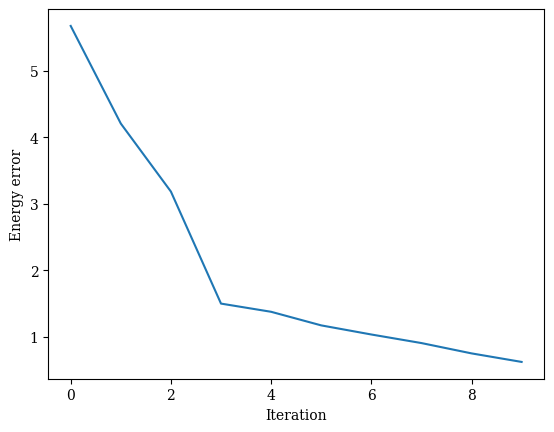

In [38]:
fig, ax = plt.subplots()
ax.plot(abs(np.array(adapt_energies) - exact_energy))
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

In [39]:
adapt_errors = np.abs(np.array(adapt_energies) - exact_energy)

## Simulate noiseless and noisy ADAPT circuits

In [40]:
noiseless_ckt_energies = []
for circuit in circuits:
    exact_estimator = Estimator()
    # The circuit needs to be transpiled to the AerSimulator target
    pass_manager = generate_preset_pass_manager(3, AerSimulator())
    isa_circuit = pass_manager.run(circuit)
    pub = (isa_circuit, h_qiskit)
    job = exact_estimator.run([pub])
    result = job.result()
    pub_result = result[0]
    exact_value = float(pub_result.data.evs)
    noiseless_ckt_energies.append(exact_value)

noiseless_ckt_errs = np.abs(np.array(noiseless_ckt_energies) - exact_energy)

Text(0.5, 1.0, 'Energy error from ADAPT circuits.')

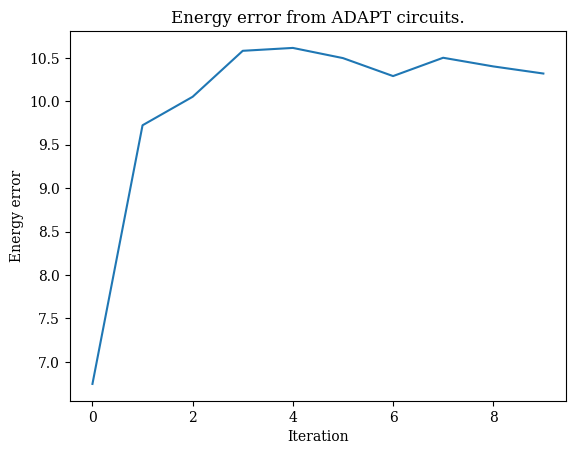

In [43]:
fig, ax = plt.subplots()
ax.plot(noiseless_ckt_errs)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")
ax.set_title("Energy error from ADAPT circuits.")

## Carry out SQD.

In [30]:
# Use a fake computer to get noise.
computer = qiskit_ibm_runtime.fake_provider.FakeTorino()
simualtor = AerSimulator(method="matrix_product_state").from_backend(computer)
sampler = Sampler(simualtor)

In [31]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

spin_a_layout = list(range(0, 12))
spin_b_layout = [12, 13, 14, 15, 19, 35, 34, 33, 32, 31, 30, 29]
initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=computer, initial_layout=initial_layout[:nq]
)


In [32]:
bit_arrays = []
counts_list = []
for circuit in circuits:
    pass_manager.pre_init = ffsim.qiskit.PRE_INIT
    to_run = pass_manager.run(circuit)
    print(f"Gate counts (w/ pre-init passes): {to_run.count_ops()}")
    job = sampler.run([to_run], shots=30_000)
    bit_array = job.result()[0].data.meas
    counts1 = bit_array.get_counts()
    counts_list.append(counts1)
    bit_arrays.append(deepcopy(bit_array))

Gate counts (w/ pre-init passes): OrderedDict({'rz': 11, 'sx': 10, 'measure': 8, 'cz': 7, 'x': 5, 'barrier': 2})
Gate counts (w/ pre-init passes): OrderedDict({'rz': 23, 'sx': 23, 'cz': 14, 'x': 8, 'measure': 8, 'barrier': 3})
Gate counts (w/ pre-init passes): OrderedDict({'sx': 34, 'rz': 32, 'cz': 21, 'x': 8, 'measure': 8, 'barrier': 4})
Gate counts (w/ pre-init passes): OrderedDict({'sx': 49, 'rz': 46, 'cz': 30, 'measure': 8, 'x': 6, 'barrier': 5})
Gate counts (w/ pre-init passes): OrderedDict({'sx': 63, 'rz': 62, 'cz': 36, 'x': 9, 'measure': 8, 'barrier': 6})
Gate counts (w/ pre-init passes): OrderedDict({'sx': 73, 'rz': 72, 'cz': 40, 'x': 8, 'measure': 8, 'barrier': 7})
Gate counts (w/ pre-init passes): OrderedDict({'sx': 86, 'rz': 83, 'cz': 45, 'x': 11, 'barrier': 8, 'measure': 8})
Gate counts (w/ pre-init passes): OrderedDict({'sx': 100, 'rz': 96, 'cz': 50, 'x': 11, 'barrier': 9, 'measure': 8})
Gate counts (w/ pre-init passes): OrderedDict({'rz': 99, 'sx': 99, 'cz': 52, 'x': 11, 

In [33]:
energies = []
errors = []

for bit_array in bit_arrays:
    print(bit_array.num_bits)
    bit_matrix = bit_array.to_bool_array()
    print(bit_matrix.shape)
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    energies.append(min_energy)
    errors.append(err)

8
(30000, 8)
8
(30000, 8)
8
(30000, 8)
8
(30000, 8)
8
(30000, 8)
8
(30000, 8)
8
(30000, 8)
8
(30000, 8)
8
(30000, 8)
8
(30000, 8)


Text(0, 0.5, 'Energy error')

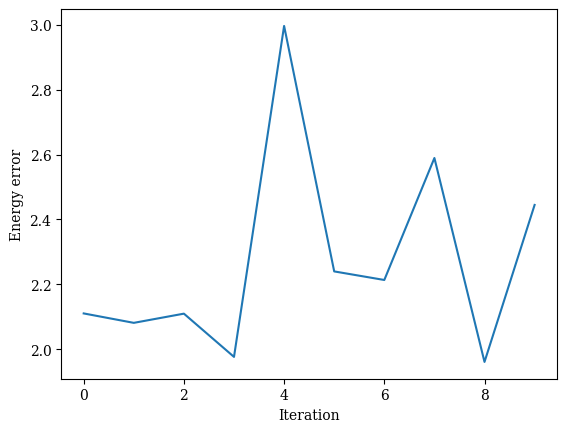

In [34]:
fig, ax = plt.subplots()
ax.plot(errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Concatenate mulitple rounds

In [35]:
stacked_energies = []
stacked_errors = []

for i in range(1, len(counts_list) + 1):
    all_counts = collections.Counter()
    tuple_of_counts = tuple(counts_list[:i])
    assert len(tuple_of_counts) == i
    for counts in tuple_of_counts:
        for bitstring, count in counts.items():
            all_counts[bitstring] += count

    bit_array = qiskit.primitives.BitArray.from_counts(all_counts)
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    stacked_energies.append(min_energy)
    stacked_errors.append(err)


Text(0, 0.5, 'Energy error')

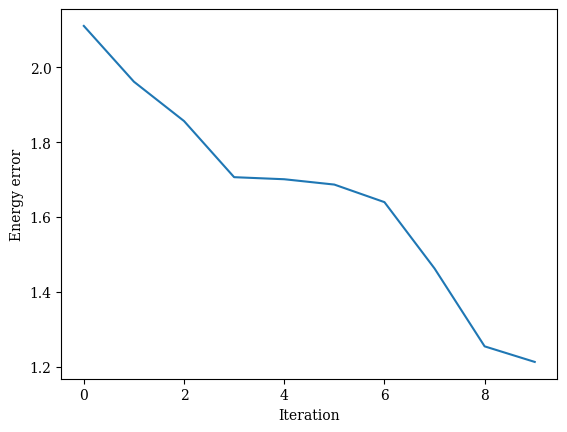

In [36]:
fig, ax = plt.subplots()
ax.plot(stacked_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Random sampling

Instead of sampling from an approximation of the ground state, make a truly random array of bits.

In [37]:
from qiskit_addon_sqd.counts import generate_bit_array_uniform

bit_array = generate_bit_array_uniform(30_000, nq, rand_seed=1)

In [38]:
bit_matrix = bit_array.to_bool_array()
eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit)
min_energy_random = np.min(eigvals)
err_random = abs(min_energy - exact_energy)
rel_err_random = err_random / abs(exact_energy)

## Plot final results

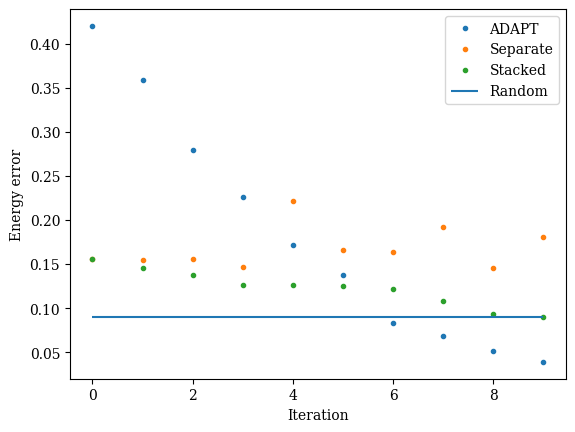

In [39]:
adapt_rel_errors = adapt_errors / abs(exact_energy)
rel_errors = np.array(errors) / abs(exact_energy)
stacked_rel_errors = np.array(stacked_errors) / abs(exact_energy)

fig, ax = plt.subplots()
ax.plot(adapt_rel_errors, '.', label="ADAPT")
ax.plot(rel_errors, '.', label="Separate")
ax.plot(stacked_rel_errors, '.', label="Stacked")
ax.hlines(rel_err_random, 0., len(rel_errors) - 1, label="Random")
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")
ax.legend()